<a href="https://colab.research.google.com/github/RizaRafeek/NLP-Sentiment-Analysis/blob/main/Sentiment_Analysis_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load the data (limiting to the top 10,000 most frequent words)
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

# 2. Understanding the Data
# NLP data is stored as numbers (indices). Each number represents a word.
print(f"Review example (encoded): {X_train[0][:10]}")

# 3. Padding (The most important NLP preprocessing step)
# Neural Networks need every input to be the same length.
# If a review is too short, we add zeros. If it's too long, we cut it.
max_length = 200
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

print(f"Padded shape: {X_train.shape}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Review example (encoded): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Padded shape: (25000, 200)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

# Define the Model
model = Sequential([
    # Layer 1: The meaningful 'coordinates' for words
    Embedding(input_dim=10000, output_dim=16, input_length=200),

    # Layer 2: Reshape the 3D data into 2D for the Dense layers
    Flatten(),

    # Layer 3: A Hidden Layer (Same logic as Churn project)
    Dense(16, activation='relu'),

    # Layer 4: Preventing overfitting
    Dropout(0.7),

    # Layer 5: The Output Layer (You correctly identified this!)
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- STEP 1: Add the Callback definition ---
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[callback])

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5858 - loss: 0.6476 - val_accuracy: 0.8587 - val_loss: 0.3456
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8636 - loss: 0.3347 - val_accuracy: 0.8489 - val_loss: 0.3391
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9095 - loss: 0.2366 - val_accuracy: 0.8631 - val_loss: 0.3438


Model Saved Successfully!


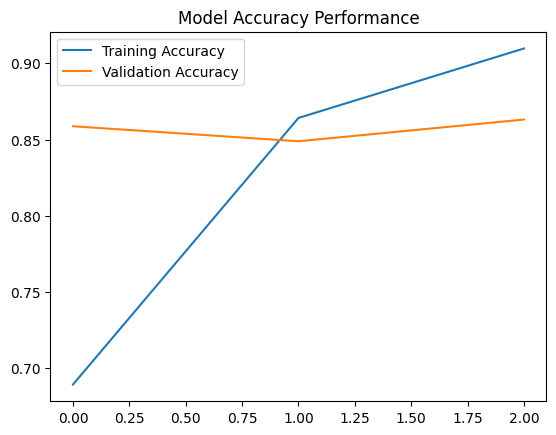

In [4]:
import matplotlib.pyplot as plt


# 1. Save the Model (The Brain Export)
model.save('sentiment_classifier.h5')
print("Model Saved Successfully!")

# 2. Plot the Results (The Performance Proof)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Performance')
plt.legend()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     12500
           1       0.84      0.90      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



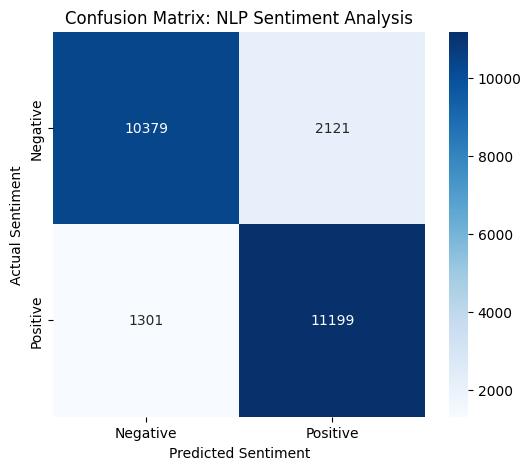

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions (Converting probabilities to 0 or 1)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 2. Print the report (Compare actual y_test with our predictions)
print(classification_report(y_test, y_pred))

# 3. Create the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix: NLP Sentiment Analysis')
plt.show()

In [6]:
import numpy as np

def test_sentiment(sentence):
    # 1. Tokenize (Turn words to numbers using the IMDB index)
    word_index = tf.keras.datasets.imdb.get_word_index()
    words = sentence.lower().split()
    # Adding +3 because IMDB indices are offset
    tokens = [word_index.get(word, 0) + 3 for word in words]

    # 2. Pad (Make it 200 long)
    padded = pad_sequences([tokens], maxlen=200, padding='post')

    # 3. Predict
    prediction = model.predict(padded)[0][0]
    result = "POSITIVE" if prediction > 0.5 else "NEGATIVE"

    print(f"Review: {sentence}")
    print(f"Confidence Score: {prediction:.4f}")
    print(f"Final Verdict: {result}")

# Try these two:
test_sentiment("This movie was a masterpiece the acting was incredible")
test_sentiment("I hated every minute of this film it was a total disaster")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Review: This movie was a masterpiece the acting was incredible
Confidence Score: 0.8004
Final Verdict: POSITIVE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Review: I hated every minute of this film it was a total disaster
Confidence Score: 0.4043
Final Verdict: NEGATIVE


In [7]:
import json

# Save the Model
model.save('final_sentiment_model.h5')

# Save the Word Index (The Dictionary)
word_index = tf.keras.datasets.imdb.get_word_index()
with open('word_index.json', 'w') as f:
    json.dump(word_index, f)

print("✅ DONE: 'final_sentiment_model.h5' and 'word_index.json' are ready for GitHub.")

✅ DONE: 'final_sentiment_model.h5' and 'word_index.json' are ready for GitHub.
